In [1]:
from sklearn.datasets import fetch_openml
from sklearn.utils import Bunch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
mnist: Bunch = fetch_openml("mnist_784", version=1, as_frame=False)
print(mnist.keys())

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])


In [3]:
X, y = mnist.data, mnist.target
print(type(X))
print(type(y))
print(X.shape)
print(y.shape)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(70000, 784)
(70000,)


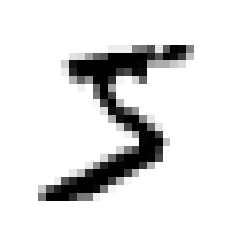

In [4]:
some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [5]:
y_int = y.astype("uint8")

In [6]:
print(X.dtype)
print(y.dtype)
print(y_int.dtype)

float64
object
uint8


In [7]:
# dataset is already split into training set (the first 60.000 images) and test set (the last 10.000 images)
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y_int[:60000], y_int[60000:]

In [8]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [9]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [10]:
sgd_clf.predict([some_digit])

array([ True])

In [11]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")
print(scores)

[0.95035 0.96035 0.9604 ]


In [12]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self

    def predict(self, X):
        return np.ones((len(X), 1), dtype=bool)

In [13]:
never_5_clf = Never5Classifier()
scores = cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")
print(scores)

[0.08875 0.09145 0.09085]


# Precision Recall Curve

In [14]:
from sklearn.model_selection import cross_val_predict
y_train_5_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [15]:
print(y_train_5.shape)
print(y_train_5)
print(y_train_5_pred.shape)
print(y_train_5_pred)

(60000,)
[ True False False ...  True False False]
(60000,)
[ True False False ...  True False False]


In [16]:
from sklearn.metrics import confusion_matrix

#                           y_true (GT)    y_pred
c_matrix = confusion_matrix(y_train_5, y_train_5_pred)

# TN FP
# FN TP
print(c_matrix)

[[53892   687]
 [ 1891  3530]]


In [17]:
from sklearn.metrics import precision_score, recall_score

print(precision_score(y_train_5, y_train_5_pred)) # == 3530 / (3530 + 687)
print(recall_score(y_train_5, y_train_5_pred)) # == 3530 / (3530 + 1891)

0.8370879772350012
0.6511713705958311


In [18]:
from sklearn.metrics import f1_score

print(f1_score(y_train_5, y_train_5_pred))

0.7325171197343846


In [19]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")
print(y_scores)
print(np.max(y_scores))
print(np.min(y_scores))

[  1200.93051237 -26883.79202424 -33072.03475406 ...  13272.12718981
  -7258.47203373 -16877.50840447]
49441.437659047755
-146348.56726173862


In [20]:
threshhold = 0
print(y_scores > threshhold)
# samke predictions earlier
print(np.array_equal(y_train_5_pred, y_scores > threshhold))

[ True False False ...  True False False]
True


In [21]:
from sklearn.metrics import precision_recall_curve

precision, recall, threshholds = precision_recall_curve(y_train_5, y_scores)

print(precision)
print(recall)
print(threshholds)
print(precision.shape)
print(recall.shape)
print(threshholds.shape)

[0.09040123 0.09038606 0.09038757 ... 1.         1.         1.        ]
[1.00000000e+00 9.99815532e-01 9.99815532e-01 ... 3.68935621e-04
 1.84467810e-04 0.00000000e+00]
[-106527.45300471 -105763.22240074 -105406.2965229  ...   38871.26391927
   42216.05562787   49441.43765905]
(59967,)
(59967,)
(59966,)


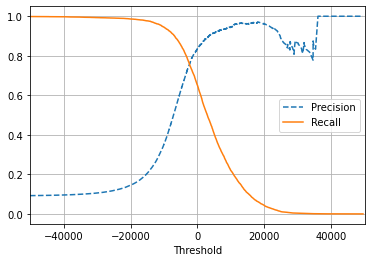

In [22]:
def plot_precision_recall_threshholds_curve(precision, recall, threshholds):
    fig, ax = plt.subplots()
    ax.plot(threshholds, precision[1:], "--", label="Precision")
    ax.plot(threshholds, recall[1:], label="Recall")
    ax.grid()
    ax.set_xlabel("Threshold")
    ax.legend(loc="center right")
    ax.set_xlim(-50000, 50000)

plot_precision_recall_threshholds_curve(precision, recall, threshholds)

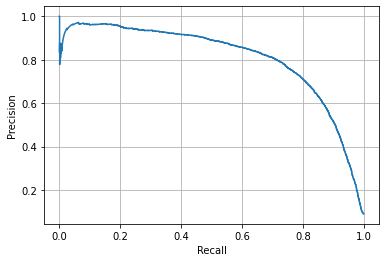

In [23]:
def plot_precision_recall_curve(precision, recall):
    fig, ax = plt.subplots()
    ax.plot(recall, precision)
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.grid()

plot_precision_recall_curve(precision, recall)

---

In [24]:
# https://numpy.org/doc/stable/reference/generated/numpy.argmax.html?highlight=argmax#numpy.argmax
threshhold_90_precision = threshholds[np.argmax(precision >= 0.9)]
print(threshhold_90_precision)

3370.0194991439557


In [25]:
y_train_90_pred = y_scores >= threshhold_90_precision

In [26]:
precision_score(y_train_5, y_train_90_pred)

0.9000345901072293

In [27]:
recall_score(y_train_5, y_train_90_pred)

0.4799852425751706

# ROC curve

In [28]:
from sklearn.metrics import roc_curve

fpr, tpr, threshholds = roc_curve(y_train_5, y_scores)

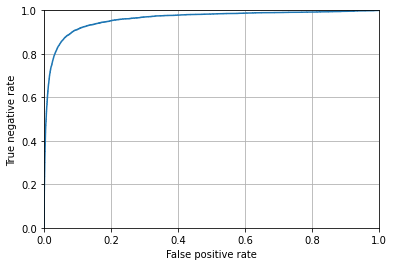

In [29]:
def plot_roc_curve(fpr, tpr):
    fix, ax = plt.subplots()
    ax.plot(fpr, tpr)
    ax.set_xlabel("False positive rate")
    ax.set_ylabel("True negative rate")
    ax.set(xlim=(0,1), ylim=(0,1))
    ax.grid()

plot_roc_curve(fpr, tpr)

In [30]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

# Multiclass Classification

In [31]:
from sklearn.svm import SVC
svm_clf = SVC()
# trained using a OvO strategie
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [32]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [33]:
np.argmax(some_digit_scores)

5

In [34]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [35]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [36]:
len(ovr_clf.estimators_)

10

In [37]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [38]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [39]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [40]:
from sklearn.preprocessing import StandardScaler
scalar = StandardScaler()
X_train_scaled = scalar.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

# Error Analysis

In [49]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)

In [67]:
print(y_train_pred)

[3 0 4 ... 5 6 8]


In [68]:
cf_matrix = confusion_matrix(y_train, y_train_pred)
print(cf_matrix)

[[5577    0   22    5    8   43   36    6  225    1]
 [   0 6400   37   24    4   44    4    7  212   10]
 [  27   27 5220   92   73   27   67   36  378   11]
 [  22   17  117 5227    2  203   27   40  403   73]
 [  12   14   41    9 5182   12   34   27  347  164]
 [  27   15   30  168   53 4444   75   14  535   60]
 [  30   15   42    3   44   97 5552    3  131    1]
 [  21   10   51   30   49   12    3 5684  195  210]
 [  17   63   48   86    3  126   25   10 5429   44]
 [  25   18   30   64  118   36    1  179  371 5107]]


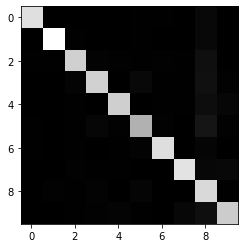

In [69]:
plt.imshow(cf_matrix, cmap="gray")

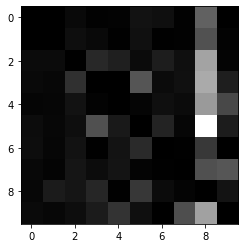

In [72]:
row_sums = np.sum(cf_matrix, axis=1, keepdims=True)
conf_matrix_normilized = cf_matrix / row_sums
np.fill_diagonal(conf_matrix_normilized, 0)
plt.imshow(conf_matrix_normilized, cmap="gray")

# Multilabel Classification

In [90]:
y_train_bigger_six = y_train > 6
y_train_odd = (y_train % 2) == 1
y_train_multiple = np.c_[y_train_bigger_six, y_train_odd]

In [91]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_train_multiple)

KNeighborsClassifier()

In [92]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [93]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_train_multiple, cv=3)

In [94]:
print(y_train_knn_pred)

[[False  True]
 [False False]
 [False False]
 ...
 [False  True]
 [False False]
 [ True False]]


In [95]:
f1_score(y_train_multiple, y_train_knn_pred, average="macro")

0.976410265560605

# Multioutput Multiclass Classification

In [126]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_noise = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_noise = X_test + noise
y_train_noise = X_train

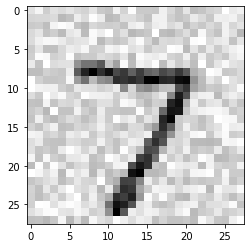

In [127]:
plt.imshow(X_test_noise[0].reshape(28,28), cmap="binary")

In [128]:
knn_clf.fit(X_train_noise, y_train_noise)

KNeighborsClassifier()

In [129]:
clean_number = knn_clf.predict([X_test_noise[0]])

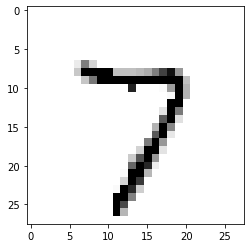

In [130]:
plt.imshow(clean_number.reshape(28,28), cmap="binary")